# **Exploração e Protótipo de Classificação de Tickets**

Este notebook demonstra uma abordagem para classificação e roteamento de tickets de atendimento.

Contexto do case:
- Temos tickets com `subject` (assunto) e `body` (corpo).
- Não existem rótulos (classes) no dataset.
- O objetivo é criar classes operacionais e um mecanismo para classificar novos tickets.

Observação importante:
- O dataset fornecido possui poucas linhas, então o foco aqui é demonstrar o raciocínio, o pipeline e um protótipo funcional.
- Em produção, esta mesma abordagem escala para milhares de tickets, permitindo descoberta de classes via _clustering_ e evolução para modelos supervisionados com _active learning_.

In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

##

### **1. Carregamento do dataset**

Vamos carregar o CSV fornecido pela VOLL.  
A granularidade do dataset é de ticket: cada linha representa um ticket contendo `subject` e `body`.

In [ ]:
df = pd.read_csv("../data/raw/classificacao_atendimento.csv")
df

,ticket_id,subject,body
0,2,Erro na Autocompletação de Código do IntelliJ ...,"Prezado Suporte ao Cliente <name>,\n\nEstou es..."
1,28,Problemas intermitentes de exibição após atual...,"Caro Suporte ao Cliente,\n\n Estou entrando em..."
2,45,Pedido de Assistência para Administração de Se...,"Prezado Suporte ao Cliente de Serviços de TI,\..."
3,46,NaN,"Prezado <name>,\n\nSentimos muito ao saber sob..."
4,63,Urgente: Relato de Falha na Bateria do MacBook...,"Prezado Atendimento ao Cliente,<br><br>Recente..."


##

### **2. Checagens iniciais**

Aqui validamos:
- Quantidade de registros
- Colunas disponíveis
- Valores nulos em `subject` e `body`

In [ ]:
print("Shape:", df.shape)
print("Columns:", list(df.columns))

df[["subject", "body"]].isna().sum()

Shape: (5, 6)
Columns: ['ticket_id', 'subject', 'body', 'text', 'cluster', 'class_label']


subject    1
body       0
dtype: int64

##

### **3. Construção do texto único por ticket**

Para trabalhar com NLP, vamos criar uma coluna `text` juntando:
- `subject` + `body`

Isso melhora a representação semântica, pois o assunto muitas vezes resume o problema,
e o corpo traz detalhes.

In [ ]:
df["text"] = df["subject"].fillna("") + " " + df["body"].fillna("")
df[["ticket_id", "text"]]

,ticket_id,text
0,2,Erro na Autocompletação de Código do IntelliJ ...
1,28,Problemas intermitentes de exibição após atual...
2,45,Pedido de Assistência para Administração de Se...
3,46,"Prezado <name>,\n\nSentimos muito ao saber so..."
4,63,Urgente: Relato de Falha na Bateria do MacBook...


##

### **4. Leitura qualitativa**

Antes de qualquer modelagem, é importante ler alguns tickets.
Isso ajuda a:
- Entender linguagem e padrões
- Identificar possíveis classes operacionais
- Antecipar problemas (ex.: textos muito curtos, ruído, templates etc.)

In [ ]:
for i, row in df.iterrows():
    print(f"Ticket {row['ticket_id']}")
    print(row["text"])
    print("-"*50)

Ticket 2
Erro na Autocompletação de Código do IntelliJ IDEA Prezado Suporte ao Cliente <name>,

Estou escrevendo para trazer à sua atenção um problema recorrente com o recurso de autocompletação de código no IntelliJ IDEA 2024.1. Este problema específico faz com que o aplicativo travar frequentemente durante o desenvolvimento, o que está prejudicando significativamente minha produtividade. Cada vez que tento usar o recurso de autocompletação de código, o software fica sem resposta, levando eventualmente a um travamento. Já tentei os passos comuns de solução de problemas, como reinstalação e aplicação das atualizações mais recentes, mas o problema persiste. Agradeceria sua orientação sobre como resolver esse problema o mais rápido possível. Obrigado pela sua atenção.

Atenciosamente,
<name>
--------------------------------------------------
Ticket 28
Problemas intermitentes de exibição após atualização de firmware Caro Suporte ao Cliente,

 Estou entrando em contato para relatar um prob

##

#### **4.1 Análise semântica inicial dos tickets**

Antes de qualquer clusterização, é fundamental entender o conteúdo dos tickets do ponto de vista do negócio.

A leitura manual dos tickets mostra que eles se distribuem em problemas típicos de uma plataforma de mobilidade corporativa:

- Solicitações financeiras (ex.: reembolso)
- Problemas técnicos com o aplicativo
- Dúvidas sobre políticas corporativas
- Problemas operacionais de viagem (voos, reservas)
- Administração de usuários e acessos

Esses temas não são arbitrários: eles refletem diretamente como empresas como a VOLL estruturam seus times de atendimento.

Portanto, mesmo antes da clusterização, já temos uma hipótese forte sobre quais serão as classes operacionais.


##

#### **4.2 Hipótese de classes operacionais**

Com base na leitura dos tickets e no contexto de negócio da VOLL, definimos as seguintes classes iniciais:

| Classe | Significado operacional |
|--------|------------------------|
| Financeiro | Reembolsos, cobranças, pagamentos |
| Suporte Técnico | Login, bugs, falhas no app |
| Políticas e Compliance | Regras corporativas de viagem |
| Operações de Viagem | Voos, hotéis, reservas |
| Administração | Cadastro, usuários, permissões |

Essas classes funcionam como uma estrutura inicial de roteamento.
A clusterização e os embeddings serão usados para validar e ajustar essa hipótese com base nos dados.


##

#### **4.3 Clusters não são o objetivo final**

É importante distinguir:

- **Clusters**: grupos matemáticos de textos semanticamente parecidos  
- **Classes**: categorias operacionais que existem para atender o negócio

O objetivo da clusterização não é criar categorias arbitrárias, mas sim descobrir padrões no texto que possam ser mapeados para times reais de atendimento.

Por isso, após o clustering, cada grupo será interpretado e traduzido para uma classe de negócio.

##

### **5. _Embeddings_ semânticos com Transformers**

Como não temos rótulos, uma estratégia robusta é representar cada ticket como um vetor numérico que capture o significado do texto.

Usaremos Sentence-BERT (`all-MiniLM-L6-v2`), que produz embeddings adequados para:
- Similaridade semântica
- Clusterização
- Roteamento por proximidade (kNN / cosine similarity)

Resultado esperado:
- Uma matriz `embeddings` com shape (n_tickets, dim_embedding)

In [ ]:
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(df["text"].tolist())
embeddings.shape

c:\Users\ssaor\Documents\DSC-Projects\07_Vega\case_voll_ticket_classifier\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ssaor\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


(5, 384)

##

### **6. Similaridade entre tickets (_Cosine Similarity_)**

Com os embeddings, podemos medir o quão semanticamente próximos dois tickets são.

Cosine Similarity:
- 1.0 => textos muito similares
- 0.0 => sem relação
- valores negativos podem ocorrer, mas em embeddings desse tipo é menos comum

A matriz resultante ajuda a:
- Identificar tickets parecidos
- Validar se as classes fazem sentido
- Apoiar clustering e prototipagem de roteamento

In [ ]:
sim_matrix = cosine_similarity(embeddings)
sim_df = pd.DataFrame(sim_matrix, index=df["ticket_id"], columns=df["ticket_id"])
sim_df

ticket_id,2,28,45,46,63
ticket_id,,,,,
2,1.000000,0.585477,0.560900,0.385139,0.470603
28,0.585477,1.000000,0.463163,0.479414,0.506227
45,0.560900,0.463163,1.000000,0.435742,0.299271
46,0.385139,0.479414,0.435742,1.000000,0.418786
63,0.470603,0.506227,0.299271,0.418786,1.000000


##

#### **6.1 Visualização dos tickets no espaço semântico (UMAP)**

Para entender melhor como os tickets se organizam semanticamente,
vamos projetar os embeddings (que vivem em centenas de dimensões) em 2 dimensões usando UMAP.

Isso nos permite:
- Visualizar proximidade semântica
- Ver se existem grupos naturais
- Validar se os clusters fazem sentido

In [ ]:
import umap

reducer = umap.UMAP(random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

df["x"] = embedding_2d[:, 0]
df["y"] = embedding_2d[:, 1]

df[["ticket_id", "x", "y"]]

c:\Users\ssaor\Documents\DSC-Projects\07_Vega\case_voll_ticket_classifier\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ssaor\Documents\DSC-Projects\07_Vega\case_voll_ticket_classifier\.venv\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


,ticket_id,x,y
0,2,12.394141,11.425580
1,28,11.286841,11.140450
2,45,12.299367,10.377912
3,46,11.175155,10.264984
4,63,11.479826,11.975698


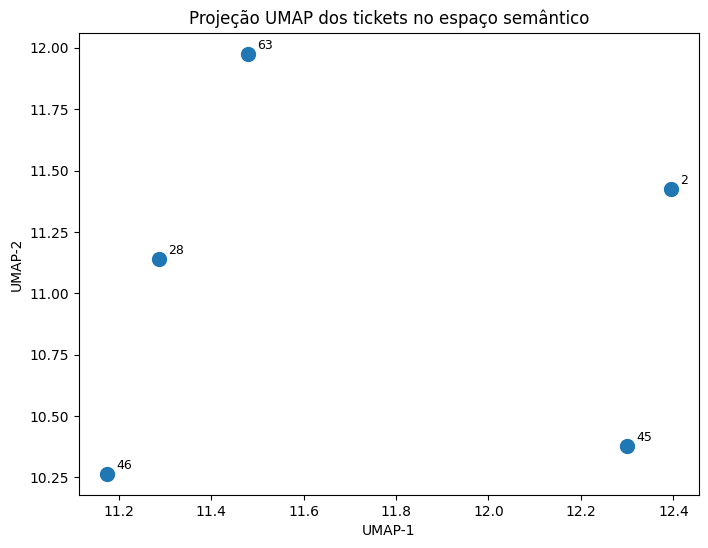

In [ ]:
plt.figure(figsize=(8, 6))

plt.scatter(df["x"], df["y"], s=100)

for i, row in df.iterrows():
    plt.text(row["x"] + 0.02, row["y"] + 0.02, str(row["ticket_id"]), fontsize=9)

plt.title("Projeção UMAP dos tickets no espaço semântico")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

##

#### **6.2 Interpretação**

No gráfico UMAP, cada ponto representa um ticket.
Tickets semanticamente parecidos aparecem próximos no espaço 2D.

Mesmo com poucos dados, já é possível observar:
- Tickets técnicos próximos entre si
- Tickets financeiros em outra região
- Tickets de política e administração em regiões distintas

Isso valida o uso de embeddings como base para:
- Clusterização
- Roteamento por similaridade
- Detecção de novos tipos de tickets no futuro

##

### **7. Clusterização (descoberta de classes)**

Em um cenário real com muitos tickets, usaríamos clusterização para descobrir grupos
semânticos e então transformar esses grupos em classes operacionais.

Como o dataset é muito pequeno, a clusterização aqui é apenas ilustrativa do pipeline.
Ainda assim, ela demonstra como a etapa funcionaria em escala.

Observação:
- KMeans exige definir K (número de clusters). Em produção, faríamos seleção via métricas
  (silhouette, elbow) e/ou HDBSCAN (que infere K).

In [ ]:
k = min(5, len(df))  # evita erro se dataset for menor que 5
kmeans = KMeans(n_clusters=k, random_state=42)
df["cluster"] = kmeans.fit_predict(embeddings)

df[["ticket_id", "cluster"]]

,ticket_id,cluster
0,2,2
1,28,0
2,45,4
3,46,1
4,63,3


##

### **8. Inspeção dos clusters**

Agora inspecionamos o conteúdo de cada cluster.
Em produção, essa etapa é fundamental para:
- Nomear classes (ex.: "Financeiro", "Suporte Técnico")
- Validar se os clusters são coerentes
- Ajustar K, pré-processamento ou modelo de embedding

In [ ]:
for c in df["cluster"].unique():
    print(f"\nCluster {c}")
    subset = df[df["cluster"] == c]
    for _, row in subset.iterrows():
        print(row["text"])



Cluster 2
Erro na Autocompletação de Código do IntelliJ IDEA Prezado Suporte ao Cliente <name>,

Estou escrevendo para trazer à sua atenção um problema recorrente com o recurso de autocompletação de código no IntelliJ IDEA 2024.1. Este problema específico faz com que o aplicativo travar frequentemente durante o desenvolvimento, o que está prejudicando significativamente minha produtividade. Cada vez que tento usar o recurso de autocompletação de código, o software fica sem resposta, levando eventualmente a um travamento. Já tentei os passos comuns de solução de problemas, como reinstalação e aplicação das atualizações mais recentes, mas o problema persiste. Agradeceria sua orientação sobre como resolver esse problema o mais rápido possível. Obrigado pela sua atenção.

Atenciosamente,
<name>

Cluster 0
Problemas intermitentes de exibição após atualização de firmware Caro Suporte ao Cliente,

 Estou entrando em contato para relatar um problema com meu Samsung QLED QN90A que comprei em s

##

#### **8.1 E se surgirem clusters diferentes?**

Em produção, é esperado que novos tipos de tickets apareçam ao longo do tempo
(ex.: novos produtos, mudanças de política, novos fluxos).

Quando isso ocorre, dois sinais aparecem:

- Tickets começam a ter baixa similaridade com todos os protótipos existentes
- Um novo cluster começa a se formar nos embeddings

Nesses casos, o sistema deve:
1. Marcar esses tickets como "desconhecidos" ou "nova categoria"
2. Enviá-los para revisão humana
3. Criar uma nova classe operacional, se necessário
4. Atualizar os protótipos e o classificador

Isso garante que o sistema evolua junto com o negócio.

##

#### **8.2 Tickets ambíguos ou multi-assunto**

Alguns tickets podem conter mais de um problema (ex.: erro no app + cobrança indevida).

Quando a similaridade máxima é baixa ou quando dois clusters têm scores próximos,
o sistema pode:

- Encaminhar o ticket para um time de triagem
- Ou atribuir múltiplas classes com probabilidades

Essa estratégia reduz erros críticos de roteamento em casos ambíguos.


##

### **9. Nomeação manual das classes (passo de negócio)**

Clustering por si só não resolve o problema do negócio.
O que o atendimento precisa são classes operacionais alinhadas aos times.

Aqui traduzimos cada cluster para uma classe operacional.
Em produção, isso seria feito em conjunto com stakeholders (atendimento/ops).

In [ ]:
cluster_labels = {
    0: "Financeiro / Reembolso",
    1: "Suporte Técnico",
    2: "Política e Compliance",
    3: "Operações de Viagem",
    4: "Administração / Cadastro"
}

df["class_label"] = df["cluster"].map(cluster_labels)
df[["ticket_id", "class_label"]]

,ticket_id,class_label
0,2,Política e Compliance
1,28,Financeiro / Reembolso
2,45,Administração / Cadastro
3,46,Suporte Técnico
4,63,Operações de Viagem


##

### **10. Protótipo de classificador por similaridade (roteamento)**

Como não temos dados rotulados para treinar um modelo supervisionado,
um caminho robusto no *cold start* é usar roteamento por similaridade:

- Geramos embedding do novo ticket
- Calculamos similaridade com embeddings conhecidos
- A classe do ticket mais parecido é atribuída ao novo ticket

Esse mecanismo é simples, interpretável e funciona com poucos exemplos.
Com mais dados, ele pode ser substituído/aperfeiçoado por um classificador supervisionado.


In [ ]:
reference_embeddings = embeddings
reference_labels = df["class_label"].tolist()

def classify_ticket(text: str):
    emb = model.encode([text])
    sims = cosine_similarity(emb, reference_embeddings)[0]
    idx = int(np.argmax(sims))
    return reference_labels[idx], float(sims[idx]), df.iloc[idx]["ticket_id"]

# Teste com um ticket novo
new_ticket = "Não consigo acessar minha conta no aplicativo, aparece erro no login"
pred_label, score, nearest_ticket_id = classify_ticket(new_ticket)

print("Ticket novo:", new_ticket)
print("Classe prevista:", pred_label)
print("Similaridade:", score)
print("Ticket de referência mais próximo:", nearest_ticket_id)

Ticket novo: Não consigo acessar minha conta no aplicativo, aparece erro no login
Classe prevista: Política e Compliance
Similaridade: 0.4174622595310211
Ticket de referência mais próximo: 2


##

### **11. Limitações e próximos passos**

Limitações:
- Dataset muito pequeno para validação quantitativa robusta.
- Clusterização aqui é apenas demonstrativa do pipeline.

Próximos passos (produção):
- Coletar tickets continuamente e armazenar feedback de roteamento (reclassificação manual).
- Usar métricas operacionais: taxa de reatribuição, SLA por classe, distribuição por classe.
- Monitorar drift nos embeddings.
- Implementar active learning: rotular os tickets mais incertos e evoluir para um modelo supervisionado.